In [1]:
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import numpy as np
import nltk
import random
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
import pandas as pd

direction =r".\News\industrial_automation"
all_text = []
all_cls = []  
content_dir = os.path.join(direction, "content")
date_dir = os.path.join(direction, "date")
all_dates = []




for i in range(1, 1680):
    file_path = os.path.join(content_dir, f"{i}.txt")
    date_file_path = os.path.join(date_dir, f"{i}.txt")
    with open(file_path, "r", encoding="utf-8") as file:
        docs_text = file.read()
    with open(date_file_path, "r", encoding="utf-8") as date_file:
        date_str = date_file.read()
    all_dates.append(pd.to_datetime(date_str, errors='coerce'))
    all_text.append(docs_text)
    all_cls.append("ev")
    

    

TFIDF_vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
TFIDF_vectors = TFIDF_vectorizer.fit_transform(all_text)


svd_model = TruncatedSVD(n_components = 10)
SVD_vectors = svd_model.fit_transform(TFIDF_vectors)
SVD_vectors.shape
svd_model.components_.shape
svd_model.singular_values_

def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    for topic_index, topic in enumerate(abs(model.components_)):
        print("\nTopic #%d:" % topic_index)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(svd_model, TFIDF_vectorizer, 10)



Topic #0:
automation manufacturing industrial robots data new robot control technology robotics

Topic #1:
canada percent manufacturing cme sales canadian ontario control devices data

Topic #2:
robot robots robotics cobot data cobots security digital welding siemens

Topic #3:
automation percent firms output rockwell siemens inflation month abb io

Topic #4:
abb ai motors power ontario security data firms energy robot

Topic #5:
abb cme ontario percent sales government rockwell canada manufacturing manufacturers

Topic #6:
rockwell abb siemens otto automation ai motors motion omron control

Topic #7:
otto percent sales motors rockwell firms isa billion amr amrs

Topic #8:
otto percent abb siemens sales automation isa motors ai billion

Topic #9:
siemens security cybersecurity otto cme abb isa bosch motion rexroth


In [2]:
df = pd.DataFrame({'Season': [date.quarter for date in all_dates], 'Year': [date.year for date in all_dates], 'Topic': SVD_vectors.argmax(axis=1)})

# Group by season, year, and topic, count the number of documents
result = df.groupby(['Season', 'Year', 'Topic']).size().reset_index(name='Count')

# Pivot the result DataFrame
result_pivoted = result.pivot_table(index=['Year', 'Season'], columns='Topic', values='Count', fill_value=0).astype(int)

# Print the pivoted result
print(result_pivoted)

Topic          0   1   2   3   4  5  6  7  8  9
Year Season                                    
2022 1       149   7   6   2   1  3  0  1  2  3
     2       124   8  10   4   1  3  2  2  0  3
     3       143   5  14   4   6  1  2  1  1  7
     4       133  10   8   4   0  3  2  3  1  1
2023 1       144   9   4   7   4  7  2  1  4  3
     2       143   7  10   9   3  4  3  3  7  5
     3       164   6   6   8   5  6  4  2  2  4
     4       353   5  13  11  12  9  5  0  1  4


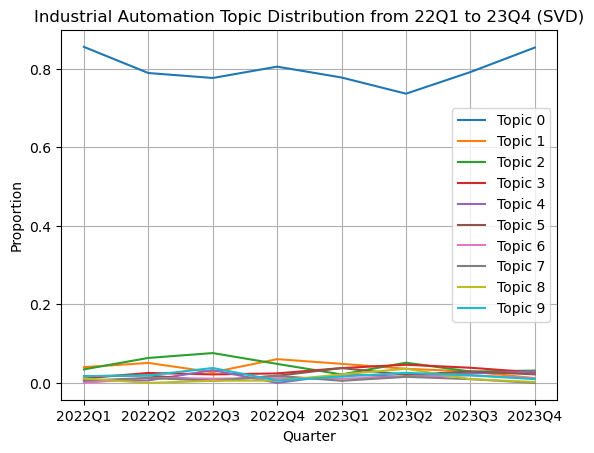

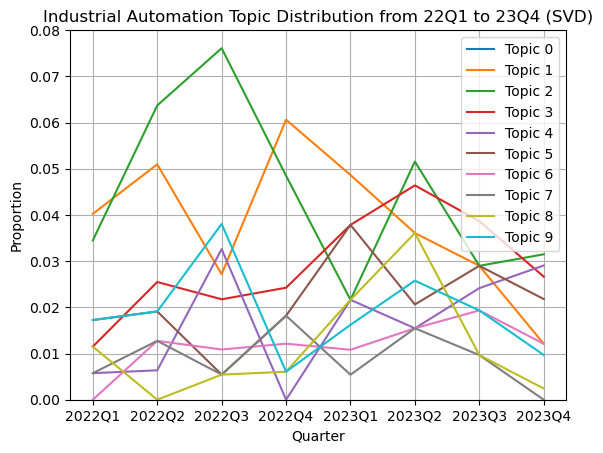

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

for (year, season) in result_pivoted.index:
    result_pivoted.loc[(year, season)] /= np.sum(result_pivoted.loc[(year, season)])

yr_season_ticks = [f"{year}Q{season}" for (year, season) in result_pivoted.index]
for topic in result_pivoted:
    plt.plot(yr_season_ticks, result_pivoted[topic].values, label=f"Topic {topic}")
plt.title("Industrial Automation Topic Distribution from 22Q1 to 23Q4 (SVD)")
plt.xlabel("Quarter")
plt.ylabel("Proportion")
plt.legend()
plt.grid()
plt.show()

yr_season_ticks = [f"{year}Q{season}" for (year, season) in result_pivoted.index]
for topic in result_pivoted:
    plt.plot(yr_season_ticks, result_pivoted[topic].values, label=f"Topic {topic}")
plt.title("Industrial Automation Topic Distribution from 22Q1 to 23Q4 (SVD)")
plt.xlabel("Quarter")
plt.ylabel("Proportion")
plt.legend()
plt.grid()
plt.ylim([0, 0.08])
plt.show()

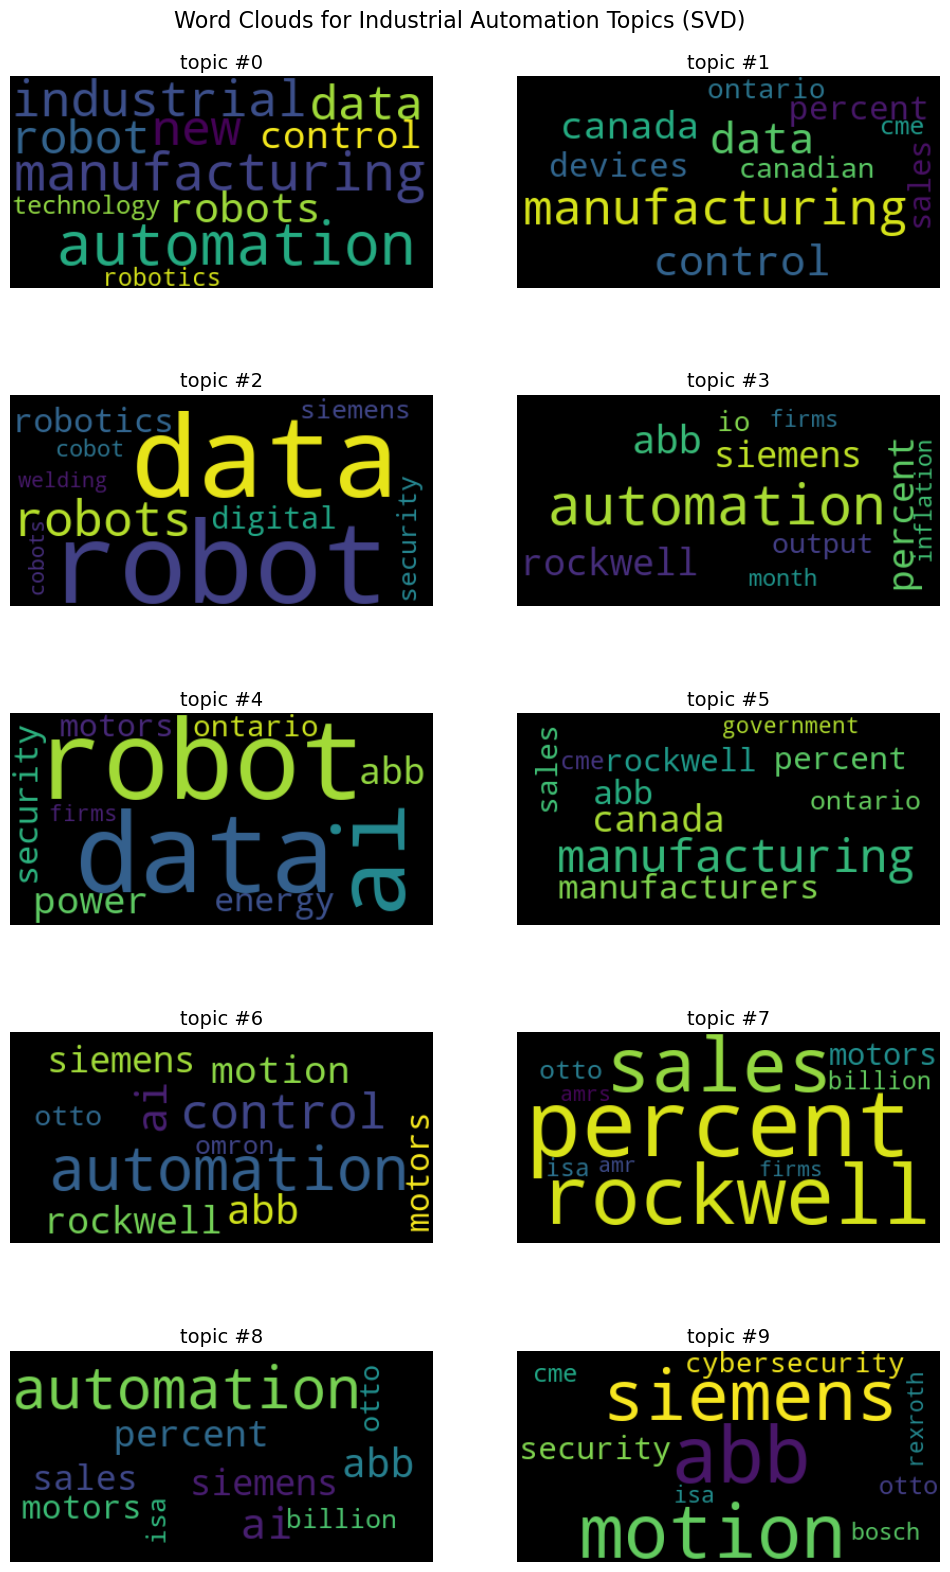

In [6]:
from wordcloud import WordCloud

vocab = TFIDF_vectorizer.get_feature_names_out()
vocab_cnt = TFIDF_vectors.toarray().sum(axis=0)
vocab_cnt_dict = dict(zip(vocab, vocab_cnt))

# retrieve topic matrix
topic_mat = []
words = TFIDF_vectorizer.get_feature_names_out()
for topic_index, topic in enumerate(abs(svd_model.components_)):
    topic_mat.append([words[i] for i in topic.argsort()[:-10 - 1:-1]])

# generate topic word clouds
plt.figure(figsize=(12, 20))
plt.suptitle("Word Clouds for Industrial Automation Topics (SVD)", y=0.9, fontsize=16)
for i in range(10):
    words = topic_mat[i]
    freqs = [vocab_cnt_dict[w] for w in words]
    wordcloud = WordCloud().generate_from_frequencies(dict(zip(words, freqs)))
    
    plt.subplot(5, 2, i + 1)
    plt.axis("off")
    plt.title(f"topic #{i}", fontsize=14)
    plt.imshow(wordcloud, interpolation="bilinear")
    
plt.show()